In [66]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [53]:
census_data = pd.read_csv("data/census.csv")
census_data = census_data.drop(['Unnamed: 0'], axis = 1)

In [54]:
mortality_data = pd.read_csv("data/mortality_grouped.csv")
mortality_data = mortality_data.drop(['Unnamed: 0'], axis = 1)

In [55]:
df = mortality_data.merge(census_data, on='ResidencePlace')
df['death_rate'] = (df['Deaths']/df['respop72017']) * 1000
df.head()

,ResidencePlace,ResidenceZone,Deaths,respop72017,death_rate
0,ADJUNTAS,RURAL,63,17971,3.505648
1,ADJUNTAS,URBANO,50,17971,2.782260
2,AGUADA,RURAL,165,38118,4.328664
3,AGUADA,URBANO,37,38118,0.970670
4,AGUADILLA,RURAL,320,53164,6.019111


In [56]:
 rural = df[df['ResidenceZone'] == 'RURAL']['death_rate']

In [57]:
 urban = df[df['ResidenceZone'] == 'URBANO']['death_rate']

In [58]:
total = pd.DataFrame(dict(death_rate = np.r_[rural, urban],
                         group = np.r_[['rural']* len(rural), 
                                      ['urban'] * len(urban)]))

In [60]:
mu_total = total.death_rate.mean()
std_total = total.death_rate.std()

In [103]:
with pm.Model() as model:
    rural_mean = pm.TruncatedNormal('rural_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)
    urban_mean = pm.TruncatedNormal('urban_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)

In [104]:
std_low = 0
std_high = 10

with model:
    rural_std = pm.Uniform('rural_std', lower = std_low,
                          upper = std_high)
    urban_std = pm.Uniform('urban_std', lower = std_low, 
                          upper = std_high)

In [105]:
with model:
    v = pm.Gamma('v', alpha = 3, beta = 1)

In [106]:
with model:
    lambda_rural = rural_std**-2
    lambda_urban = urban_std**-2
    
    rural_try = pm.StudentT('rural', nu = v, mu = rural_mean, 
                            lam = lambda_rural, observed = rural)
    urban_try = pm.StudentT('urban', nu = v, mu = urban_mean, 
                           lam = lambda_urban, observed = urban)

In [107]:
with model:
    diff_of_means = pm.Deterministic('difference of means', 
                                     rural_mean - urban_mean)
    
    diff_of_stds = pm.Deterministic('difference of stds', 
                                    rural_std - urban_std)
    
    effect_size = pm.Deterministic('effect size',
                                  diff_of_means / np.sqrt((rural_std**2 + urban_std**2) / 2))

In [108]:
with model:
    trace = pm.sample(20000, cores = 2, tune = 15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, urban_std, rural_std, urban_mean, rural_mean]
Sampling 2 chains: 100%|██████████| 70000/70000 [01:22<00:00, 845.92draws/s] 


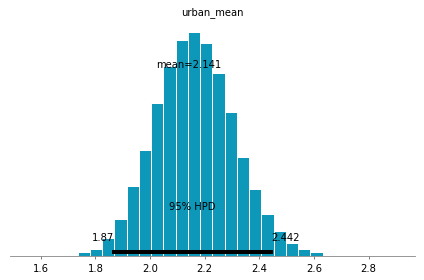

In [113]:
pm.plot_posterior(trace, varnames = ['urban_mean'], color = '#0d98ba')
plt.savefig('figs/urban_mean.png')

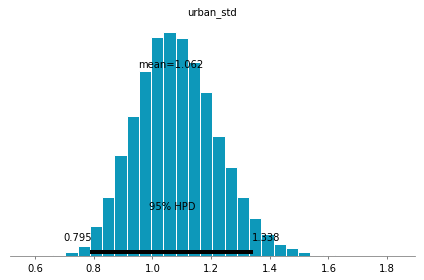

In [114]:
pm.plot_posterior(trace, varnames = ['urban_std'], color = '#0d98ba')
plt.savefig('figs/urban_std.png')

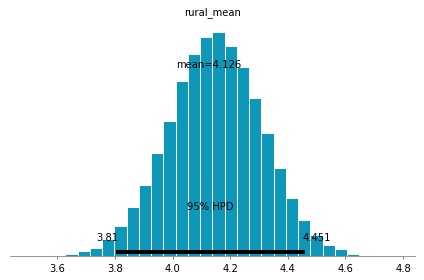

In [115]:
pm.plot_posterior(trace, varnames = ['rural_mean'], color = '#0d98ba')
plt.savefig('figs/rural_mean.png')

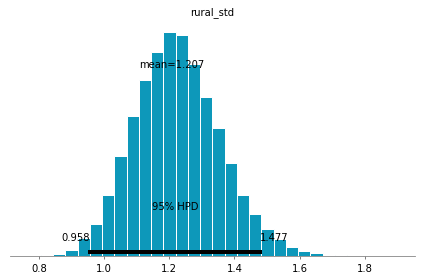

In [124]:
pm.plot_posterior(trace, varnames = ['rural_std'], color = '#0d98ba')
plt.savefig('figs/rural_std.png')

In [120]:
pm.summary(trace, varnames = ['urban_mean', 
                              'urban_std',
                              'rural_mean',
                              'rural_std']).to_csv('data/inference_summary.csv')

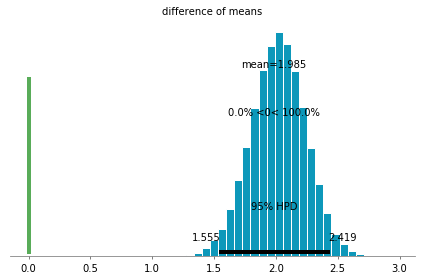

In [128]:
pm.plot_posterior(trace, varnames = ['difference of means'], color = '#0d98ba', ref_val=0)
plt.savefig('figs/difference_of_means.png')

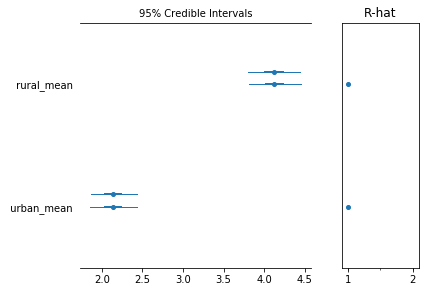

In [129]:
pm.forestplot(trace, varnames = ['rural_mean', 'urban_mean'])
plt.savefig('figs/forestplot_means.png')